# Word Segmentation on ZeroSpeech'17 English CPC-Big Codes

Copyright (c) 2021 Herman Kamper, MIT License

Train a segmental autoencoding recurrent neural network (segmental AE-RNN) and perform word segmentation on encoded ZeroSpeech'17 English.

## Preliminaries

In [3]:
from datetime import datetime
from pathlib import Path
from scipy.stats import gamma
from sklearn import cluster
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import sys
import torch
import torch.nn as nn

sys.path.append("..")

from seg_aernn import datasets, models, viterbi
from utils import eval_segmentation

## Utility functions

In [4]:
def get_segmented_sentence(ids, boundaries):
    output = ""
    cur_word = []
    for i_symbol, boundary in enumerate(boundaries):
        cur_word.append(id_to_symbol[ids[i_symbol]])
        if boundary:
            output += "_".join(cur_word)
            output += " "
            cur_word = []
    return output.strip()

In [5]:
# Duration penalty functions

"""
# Histogram
histogram = np.array([
    0, 1.66322800e-01, 2.35838129e-01, 2.10609187e-01,
    1.48025482e-01, 9.42918160e-02, 5.84211098e-02, 3.64679480e-02,
    2.18264741e-02, 1.25420784e-02, 7.18500018e-03, 4.27118399e-03,
    1.73743077e-03, 1.19448366e-03, 7.42027726e-04, 2.89571796e-04,
    2.35277084e-04, 0.00001, 0.00001, 0.00001, 0.00001, 0.00001
    ])  # to-do: check this
histogram = histogram/np.sum(histogram)
def neg_log_hist(dur):
    return -np.log(0 if dur >= len(histogram) else histogram[dur])

# Cached Gamma
# shape, loc, scale = (2.3, 0, 1.3)  # VQ-VAE
shape, loc, scale = (2.6, 0, 1.8)    # CPC-big
# shape, loc, scale = (2.5, 0, 1.5)    # CPC-big (Gamma)
gamma_cache = []
for dur in range(200):
    gamma_cache.append(gamma.pdf(dur, shape, loc, scale))
gamma_cache = np.array(gamma_cache)/np.sum(gamma_cache)
def neg_log_gamma(dur):
    if dur < 200:
        return -np.log(gamma_cache[dur])
    else:
        return -np.log(0)
"""
    
# Chorowski
def neg_chorowski(dur):
    return -(dur - 1)

## Data

In [6]:
# Dataset
vq_model = "cpc_big"
dataset = "zs2017_en"
split = "train"
seg_tag = "phoneseg_dp_penalized"

# Paths
seg_dir = (
    Path("../../vqwordseg/exp")/vq_model/dataset/split/seg_tag/"intervals"
    )
# word_ref_dir = Path("../../vqwordseg/data")/dataset/"word_intervals"

In [7]:
# Read phone segmentation
phoneseg_interval_dict = {}
print("Reading: {}".format(seg_dir))
phoneseg_interval_dict = eval_segmentation.get_intervals_from_dir(seg_dir)
utterances = phoneseg_interval_dict.keys()

Reading: ../../vqwordseg/exp/cpc_big/zs2017_en/train/phoneseg_dp_penalized/intervals


100%|██████████| 74785/74785 [22:19<00:00, 55.84it/s] 


In [8]:
# Temp
# utterances = list(utterances)[:15000]

In [9]:
"""
# Merge repeated codes (only possible for intervals > 15 frames)
merged_dict = {}
for utt_key in tqdm(phoneseg_interval_dict):
    i_token = 0
    while i_token < len(phoneseg_interval_dict[utt_key]) - 1:
        cur_start, cur_end, cur_label = phoneseg_interval_dict[utt_key][i_token]
        next_start, next_end, next_label = phoneseg_interval_dict[utt_key][i_token + 1]
        if cur_label == next_label:
            phoneseg_interval_dict[utt_key].pop(i_token)
            phoneseg_interval_dict[utt_key].pop(i_token)
            phoneseg_interval_dict[utt_key].insert(
                i_token,
                (cur_start, next_end, cur_label)
                )
        else:
            i_token += 1
"""

'\n# Merge repeated codes (only possible for intervals > 15 frames)\nmerged_dict = {}\nfor utt_key in tqdm(phoneseg_interval_dict):\n    i_token = 0\n    while i_token < len(phoneseg_interval_dict[utt_key]) - 1:\n        cur_start, cur_end, cur_label = phoneseg_interval_dict[utt_key][i_token]\n        next_start, next_end, next_label = phoneseg_interval_dict[utt_key][i_token + 1]\n        if cur_label == next_label:\n            phoneseg_interval_dict[utt_key].pop(i_token)\n            phoneseg_interval_dict[utt_key].pop(i_token)\n            phoneseg_interval_dict[utt_key].insert(\n                i_token,\n                (cur_start, next_end, cur_label)\n                )\n        else:\n            i_token += 1\n'

In [10]:
prepared_text = []
# n_max_sentence_length = 800
for utt_key in tqdm(utterances):
    prepared_text.append(
        "_".join([i[2] for i in phoneseg_interval_dict[utt_key]])
#         "_".join([i[2] for i in phoneseg_interval_dict[utt_key]][:n_max_sentence_length])
        )
    
print(prepared_text[0])

100%|██████████| 74785/74785 [00:00<00:00, 463659.90it/s]

28_26_5_11_2_23_1_34_15_26_5_27_23_17_5_40_18_20_6_33_44_0_25_40_38


In [11]:
# Vocabulary
PAD_SYMBOL      = "<pad>"
SOS_SYMBOL      = "<s>"    # start of sentence
EOS_SYMBOL      = "</s>"   # end of sentence
BOUNDARY_SYMBOL = " "      # word boundary
symbols = set()
for sentence in prepared_text:
    for char in sentence.split("_"):
        symbols.add(char)
SYMBOLS = [PAD_SYMBOL, SOS_SYMBOL, EOS_SYMBOL, BOUNDARY_SYMBOL] + (sorted(list(symbols)))
symbol_to_id = {s: i for i, s in enumerate(SYMBOLS)}
id_to_symbol = {i: s for i, s in enumerate(SYMBOLS)}

def text_to_id(text, add_sos_eos=False):
    """
    Convert text to a list of symbol IDs.

    Sentence start and end symbols can be added by setting `add_sos_eos`.
    """
    symbol_ids = []
    for word in text.split(" "):
        for code in word.split("_"):
            symbol_ids.append(symbol_to_id[code])
        symbol_ids.append(symbol_to_id[BOUNDARY_SYMBOL])
    symbol_ids = symbol_ids[:-1]  # remove last space

    if add_sos_eos:
        return [symbol_to_id[SOS_SYMBOL]] + symbol_ids + [symbol_to_id[EOS_SYMBOL]]
    else:
        return symbol_ids

print(text_to_id(prepared_text[0]))
print([id_to_symbol[i] for i in text_to_id(prepared_text[0])])

[25, 23, 49, 7, 16, 20, 5, 32, 11, 23, 49, 24, 20, 13, 49, 39, 14, 17, 50, 31, 43, 4, 22, 39, 36]
['28', '26', '5', '11', '2', '23', '1', '34', '15', '26', '5', '27', '23', '17', '5', '40', '18', '20', '6', '33', '44', '0', '25', '40', '38']


In [12]:
# First three words of training data
word_dataset = datasets.WordDataset(prepared_text, text_to_id)
for i in range(7):
    sample = word_dataset[i]
    print("_".join([id_to_symbol[i] for i in sample.numpy()]))

28_26_5_11_2_23_1_34_15_26_5_27_23_17_5_40_18_20_6_33_44_0_25_40_38
28_14_26_30_27_43_44_32_14_10_42_17_33_43_28_45_14_10_17_26_41_47_15_9_44_45_43_47_24_29_18_6_42_33_10_11_2_23_47_24_29_42_14_1_10_27_3_40_21_45_37_18_20_22_15_9_38
13
27_23_47_26_41_42_43
13_36_39_14_1_34_26_5_25_10_42_37_18_20_22_9_38
13_36_39_37_22_10_44_14_10_47_24_29_46_2_23_10_17_30_38
28_44_32_23_37_18_20_6_27_23_27_23_38


In [13]:
# Data

cur_val_sentences = prepared_text[-1000:]
cur_train_sentences = prepared_text
# cur_train_sentences = prepared_text[:15000]

# Random boundaries
np.random.seed(42)
# cur_train_sentences = insert_random_boundaries(cur_train_sentences)
# cur_val_sentences = insert_random_boundaries(cur_val_sentences)

print("No. train sentences:", len(cur_train_sentences))
print("Examples:", cur_train_sentences[:3])
print("Min length: ", min([len(i.split("_")) for i in cur_train_sentences]))
print("Max length: ", max([len(i.split("_")) for i in cur_train_sentences]))
print("Mean length: {:.4f}".format(np.mean([len(i.split("_")) for i in cur_train_sentences])))

No. train sentences: 74785
Examples: ['28_26_5_11_2_23_1_34_15_26_5_27_23_17_5_40_18_20_6_33_44_0_25_40_38', '28_14_26_30_27_43_44_32_14_10_42_17_33_43_28_45_14_10_17_26_41_47_15_9_44_45_43_47_24_29_18_6_42_33_10_11_2_23_47_24_29_42_14_1_10_27_3_40_21_45_37_18_20_22_15_9_38', '13']
Min length:  1
Max length:  254
Mean length: 31.6870


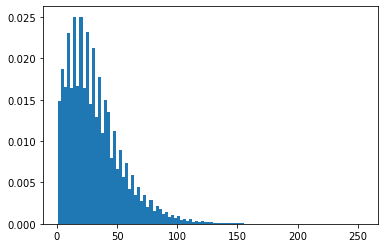

In [14]:
plt.hist([len(i.split("_")) for i in cur_train_sentences], 100, density=True)
plt.show()

## Model

In [24]:
# AE-RNN model
n_symbols = len(SYMBOLS)
symbol_embedding_dim = 10  # 25
hidden_dim = 500  # 250  # 500  # 1000  # 200
embedding_dim = 50  # 150  # 300  # 25
teacher_forcing_ratio = 0.5  # 1.0  # 0.5  # 1.0
n_encoder_layers = 1  # 1  # 3  # 10
n_decoder_layers = 1  # 1  # 1
batch_size = 32  # 32*3  # 32
learning_rate = 0.001  # 0.001
input_dropout = 0.0  # 0.0 # 0.5
dropout = 0.0
n_symbols_max = 50  # 25
# n_epochs_max = 5
n_epochs_max = None  # determined from n_max_steps and batch size
n_steps_max = 1500  # 1500  # 2500  # 1000  # None
# n_steps_max = None  # Only use n_epochs_max
bidirectional_encoder = False  # False

encoder = models.Encoder(
    n_symbols=n_symbols,
    symbol_embedding_dim=symbol_embedding_dim,
    hidden_dim=hidden_dim,
    embedding_dim=embedding_dim,
    n_layers=n_encoder_layers,
    dropout=dropout,
    input_dropout=input_dropout,
    bidirectional=bidirectional_encoder
    )
decoder = models.Decoder1(
    n_symbols=n_symbols,
    symbol_embedding_dim=symbol_embedding_dim,
    hidden_dim=hidden_dim,
    embedding_dim=embedding_dim,
    n_layers=n_decoder_layers,
    sos_id = symbol_to_id[SOS_SYMBOL],
    teacher_forcing_ratio=teacher_forcing_ratio,
    dropout=dropout
    )
# decoder = models.Decoder2(
#     n_symbols=n_symbols,
#     hidden_dim=hidden_dim,
#     embedding_dim=embedding_dim,
#     n_layers=n_decoder_layers,
#     dropout=dropout
#     )
model = models.EncoderDecoder(encoder, decoder)

## Pre-training

In [25]:
# Training device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Random seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Training data
train_dataset = datasets.WordDataset(
    cur_train_sentences, text_to_id, n_symbols_max=n_symbols_max
    )
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    collate_fn=datasets.pad_collate
    )

# Validation data
val_dataset = datasets.WordDataset(cur_val_sentences, text_to_id)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True,
    collate_fn=datasets.pad_collate
    )

# Loss
criterion = nn.NLLLoss(
    reduction="sum", ignore_index=symbol_to_id[PAD_SYMBOL]
    )
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

if n_epochs_max is None:
    steps_per_epoch = np.ceil(len(cur_train_sentences)/batch_size)
    n_epochs_max = int(np.ceil(n_steps_max/steps_per_epoch))

i_step = 0
for i_epoch in range(n_epochs_max):

    # Training
    model.train()
    train_losses = []
    for i_batch, (data, data_lengths) in enumerate(tqdm(train_loader)):
        optimiser.zero_grad()
        data = data.to(device)       
        encoder_embedding, decoder_output = model(
            data, data_lengths, data, data_lengths
            )

        loss = criterion(
            decoder_output.contiguous().view(-1, decoder_output.size(-1)),
            data.contiguous().view(-1)
            )
        loss /= len(data_lengths)
        loss.backward()
        optimiser.step()
        train_losses.append(loss.item())
        i_step += 1
        if i_step == n_steps_max and n_steps_max is not None:
            break
    
    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for i_batch, (data, data_lengths) in enumerate(val_loader):
            data = data.to(device)            
            encoder_embedding, decoder_output = model(
                data, data_lengths, data, data_lengths
                )

            loss = criterion(
                decoder_output.contiguous().view(-1,
                decoder_output.size(-1)), data.contiguous().view(-1)
                )
            loss /= len(data_lengths)
            val_losses.append(loss.item())
    
    print(
        "Epoch {}, train loss: {:.3f}, val loss: {:.3f}".format(
        i_epoch,
        np.mean(train_losses),
        np.mean(val_losses))
        )
    sys.stdout.flush()

    if i_step == n_steps_max and n_steps_max is not None:
        break

100%|██████████| 2338/2338 [01:30<00:00, 25.80it/s]


Epoch 0, train loss: 72.230, val loss: 73.156


  7%|▋         | 161/2338 [00:06<01:21, 26.75it/s]


Epoch 1, train loss: 61.438, val loss: 70.128


In [26]:
# Examples without segmentation

# Apply to validation data
model.eval()
with torch.no_grad():
    for i_batch, (data, data_lengths) in enumerate(val_loader):
        data = data.to(device)
        encoder_embedding, decoder_output = model(
            data, data_lengths, data, data_lengths
            )
        
        y, log_probs = model.decoder.greedy_decode(
            encoder_embedding,
            max_length=25,
            )
        x = data.cpu().numpy()
        
        for i_input in range(y.shape[0]):
            # Only print up to EOS symbol
            input_symbols = []
            for i in x[i_input]:
                if i == symbol_to_id[EOS_SYMBOL] or i == symbol_to_id[PAD_SYMBOL]:
                    break
                input_symbols.append(id_to_symbol[i])
            output_symbols = []
            for i in y[i_input]:
                if i == symbol_to_id[EOS_SYMBOL] or i == symbol_to_id[PAD_SYMBOL]:
                    break
                output_symbols.append(id_to_symbol[i])

            print("Input: ", "_".join(input_symbols))
            print("Output:", "_".join(output_symbols))
            print()
            
            if i_input == 10:
                break
        
        break

Input:  10_43_37_18_20_22_15_38
Output: 10_42_37_18_20_6_38_19_38_19_38_19_7_19_7_7_7_7

Input:  13_35_23_17_39_47_10_42_1_34_15_20_22_13_15_11_49_34_15_9_42_17_40_21_35_46_42_17_24_15_9_44_14_33_24_15_9_44_25_17_24_15_9_17_36_0_47_24_29_25_17_36_39_2_46_42_40_21_48_37_18_22_5_44_0_37_18_22_15_9_42_47_10_42_37_18_20_22_29_11_45_14_1_34_40_21_0_32_23_37_18_20_6_38
Output: 13_35_23_17_36_39_47_47_10_42_47_15_18_20_6_11_14_47_15_9_42_37_18_22_15

Input:  16_44_32_43_15_18_6_22_5_11_45_32_43_34_15_9
Output: 16_45_14_34_15_9_42_37_18_6_44_0_14_1_10_42_14_1_34_38_38_38_19_38_19

Input:  13_41_27_14_47_15_9_46_3_33_10_27_43_15_9_11_45_30_25_40_43
Output: 13_41_27_23_47_15_9_3_33_44_0_32_23_47_15_9_42_1_34_15_9_38_38_38_38

Input:  13_5_42_47_29_8_44_0_14_10_42_37_22_42_2_23_47_9_38
Output: 13_5_47_47_29_44_0_14_1_10_42_47_15_9_42_47_15_38_38_38_38_19_38_19_38

Input:  44_0_25_40_10_42_14_47_15_41_37_18_22_15_9_42_37_18_6_22_24_5_21_2_46_42_26_33_10_11_45_14_15_10_40_38
Output: 44_0_25_40_21_4

## Segmentation

In [27]:
# Utterances for evaluation
n_eval_utterances = len(prepared_text)  # 1000  # 10000  # 1000
# n_eval_utterances = 10000
# eval_sentences = prepared_text[-n_eval_utterances:]  # val sentences
# eval_utterances = list(utterances)[-n_eval_utterances:]
eval_sentences = prepared_text[:n_eval_utterances]
eval_utterances = list(utterances)[:n_eval_utterances]

In [28]:
# Embed segments

# Random seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Data
sentences = eval_sentences
# sentences = cur_val_sentences
interval_dataset = datasets.SentenceIntervalDataset(
    sentences,
    text_to_id,
    join_char="_"
    )
segment_loader = DataLoader(
    interval_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    collate_fn=datasets.pad_collate,
    drop_last=False
    )

# Apply model to data
model.decoder.teacher_forcing_ratio = 1.0
model.eval()
rnn_losses = []
lengths = []
eos = []
with torch.no_grad():
    for i_batch, (data, data_lengths) in enumerate(tqdm(segment_loader)):
        data = data.to(device)
        
        encoder_embedding, decoder_output = model(
            data, data_lengths, data, data_lengths
            )

        for i_item in range(data.shape[0]):
            item_loss = criterion(
                decoder_output[i_item].contiguous().view(-1,
                decoder_output[i_item].size(-1)),
                data[i_item].contiguous().view(-1)
                )
            rnn_losses.append(item_loss.cpu().numpy())
            lengths.append(data_lengths[i_item])

100%|██████████| 881669/881669 [1:28:47<00:00, 165.49it/s] 


In [29]:
# Segment

# dur_weight = 1.5  # Chorowski
dur_weight = 3.0
# dur_weight = 1.0

i_item = 0
losses = []
cur_segmented_sentences = []
for i_sentence, intervals in enumerate(tqdm(interval_dataset.intervals)):
    
    # Costs for segment intervals
    costs = np.inf*np.ones(len(intervals))
    i_eos = intervals[-1][-1]
    for i_seg, interval in enumerate(intervals):
        if interval is None:
            continue
        i_start, i_end = interval
        dur = i_end - i_start
        assert dur == lengths[i_item]
        eos = (i_end == i_eos)  # end-of-sequence
        
        # Chorowski
        costs[i_seg] = (
            rnn_losses[i_item]
            + dur_weight*neg_chorowski(dur)
            )
        
#         # Gamma
#         costs[i_seg] = (
#             rnn_losses[i_item]
#             + dur_weight*neg_log_gamma(dur)
#             + np.log(np.sum(gamma_cache**dur_weight))
#             )
        
#         # Poisson
#         costs[i_seg] = (
#             rnn_losses[i_item]
#             + neg_log_poisson(dur)
#             )

#         # Histogram
#         costs[i_seg] = (
#             rnn_losses[i_item]
#             + dur_weight*(neg_log_hist(dur))
#             + np.log(np.sum(histogram**dur_weight))
#             )
    
#         # Sequence boundary
#         alpha = 0.3  # 0.3  # 0.9
#         if eos:
#             costs[i_seg] += -np.log(alpha)
#         else:
#             costs[i_seg] += -np.log(1 - alpha)
# #             K = 5000
# #             costs[i_seg] += -np.log((1 - alpha)/K)

        # Temp
#         if dur > 10 or dur <= 1:
#             costs[i_seg] = +np.inf
        i_item += 1
    
    # Viterbi segmentation
    n_frames = len(interval_dataset.sentences[i_sentence])
    summed_cost, boundaries = viterbi.custom_viterbi(costs, n_frames)
    losses.append(summed_cost)
    
    reference_sentence = sentences[i_sentence]
    segmented_sentence = get_segmented_sentence(
            interval_dataset.sentences[i_sentence],
            boundaries
            )
    cur_segmented_sentences.append(segmented_sentence)
#     # Print examples of the first few sentences
#     if i_sentence < 10:
#         print(reference_sentence)
#         print(segmented_sentence)
#         print()
    
print("NLL: {:.4f}".format(np.sum(losses)))

100%|██████████| 74785/74785 [01:01<00:00, 1220.53it/s]

NLL: -4650737.8463


## Evaluation

In [30]:
print(f"{eval_utterances[0]}:")
print(cur_segmented_sentences[0])

# # To evaluate gold segmentation:
# cur_segmented_sentences = prepared_text_gold[:n_eval_utterances]
# print(cur_segmented_sentences[0])

s1724_107699-107852:
28_26_5_11_2_23_1_34_15 26_5_27_23 17_5_40 18_20_6_33_44_0_25_40_38


In [31]:
# Convert segmentation to intervals
segmentation_interval_dict = {}
for i_utt, utt_key in tqdm(enumerate(eval_utterances)):
    words_segmented = cur_segmented_sentences[i_utt].split(" ")
    word_start = 0
    word_label = ""
    i_word = 0
    segmentation_interval_dict[utt_key] = []
    for (phone_start, phone_end,
            phone_label) in phoneseg_interval_dict[utt_key]:
        word_label += phone_label + "_"
        if words_segmented[i_word] == word_label[:-1]:
            segmentation_interval_dict[utt_key].append((
                word_start, phone_end, word_label[:-1]
                ))
            word_label = ""
            word_start = phone_end
            i_word += 1

#     if i_utt < 10:
#         print(segmentation_interval_dict[utt_key])
#         print(word_ref_interval_dict[utt_key])
#         print()        

74785it [00:00, 75948.90it/s]


In [32]:
# Write intervals to a directory
output_tag = "wordseg_segaernn_{}".format(seg_tag.replace("phoneseg_", ""))
output_dir = (
    Path("../../vqwordseg/exp")/vq_model/dataset/split/output_tag/"intervals"
    )
output_dir.mkdir(exist_ok=True, parents=True)
print(f"Writing to: {output_dir}")
for utt_key in tqdm(segmentation_interval_dict):
    with open((output_dir/utt_key).with_suffix(".txt"), "w") as f:
        for (i_segment, (start, end, label)) in enumerate(segmentation_interval_dict[utt_key]):
            f.write(f"{start:d} {end:d} {label}_\n")

  1%|▏         | 1117/74785 [00:00<00:06, 11168.68it/s]

Writing to: ../../vqwordseg/exp/cpc_big/zs2017_en/train/wordseg_segaernn_dp_penalized/intervals


100%|██████████| 74785/74785 [00:09<00:00, 7803.06it/s] 
